In [1]:
"""
Mini-project - Visual
Course: Deep learning, Aalborg university
Auther: Emil Lytje-dorfman, Jacob Vitfell Køpke, Rune Drongesen
-------
This code runs the given hyperparameters found in the sweep.
After running the CNN it logs loss, and accuracy to WandB.
At last it plots 10 images with predicted and true labels
and the a confusion matrix showing if the model overfits or not.
-------
"""

'\nMini-project - Visual\nCourse: Deep learning, Aalborg university\nAuther: Emil Lytje-dorfman, Jacob Vitfell Køpke, Rune Drongesen\n-------\nThis code runs the given hyperparameters found in the sweep.\nAfter running the CNN it logs loss, and accuracy to WandB.\nAt last it plots 10 images with predicted and true labels\nand the a confusion matrix showing if the model overfits or not.\n-------\n'

In [2]:
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Import all necessary PyTorch and Torch Vision packages
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision.utils import make_grid

# Load the dataset to train for calssifying cracked and non-cracked surfaces
from PIL import Image
from collections import defaultdict

# Load package to measure the time it takes to run the training and test
from pytictoc import TicToc
from tqdm import trange
from tqdm import tqdm

import wandb

import torch
import torch.nn as nn

t = TicToc()

In [3]:
main_data_path = "archive"

In [4]:
# Function that splits data into a training and test set with user defined ratio
def split_data(data, training_ratio):
  train_size = int(training_ratio * len(data))
  test_size = len(data) - train_size
  train_set, test_set = random_split(data, [train_size, test_size])
  return train_set, test_set


In [5]:
# Path to the 12000 sampled data used in this project
sample_path = 'data_sampled'

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
# Define transforms for the image data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.RandomVerticalFlip(p=0.5),
    transforms.v2.RandomApply(transforms=[transforms.v2.RandomRotation(degrees=(-90, -90))], p=0.5),
    transforms.v2.RandomApply(transforms=[transforms.v2.RandomRotation(degrees=(90, 90))], p=0.5),
    transforms.v2.RandomApply(transforms=[transforms.v2.RandomRotation(degrees=(180, 180))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Hyper parameters
dout = 0.2
bs = 128
learn_rate = 0.0001
epoch = 25

# Loop through the sampled data and apply the transforms
print(f"Dropout: {dout}")
print(f"Batch Size: {bs}")
print(f"Learning Rate: {learn_rate}")
print(f"epochs: {epoch}")

wandb.init(project="Mini_project_2", config={"learning_rate": learn_rate, "epochs": epoch, "Batch size": bs, "Dropout": dout})

# Load data
sampled_data = datasets.ImageFolder(sample_path, transform = transform)
train_dataset, val_dataset = split_data(sampled_data, 0.8)
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=True)

# Load the pre-trained ResNet-18 model
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# Freeze all layers except the last two
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.layer4.parameters():
    param.requires_grad = True

# Modify the last layer for binary classification
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(dout),
    nn.Linear(256, 84),
    nn.ReLU(),
    nn.Dropout(dout),
    nn.Linear(84, 1)
)
resnet.to(device)

correct_predictions = []
incorrect_predictions = []
CM_pred_label = []
CM_gt_label = []

# Train the model
for _ in range(epoch):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(resnet.parameters(), lr=learn_rate)
    running_loss = 0.0
    cumu_val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    resnet.train()
    for (inputs, labels) in tqdm(train_loader, desc="Loop", position=0, leave=True):
        inputs, labels = inputs.to(device), labels.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        predicted_labels = torch.round(torch.sigmoid(outputs))      # Convert logits to binary predictions (0 or 1)
        correct_preds += (predicted_labels == labels).sum().item()  # Count correctly classified samples
        total_preds += labels.size(0)  

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_preds / total_preds

    correct_preds = 0
    total_preds = 0

    resnet.eval() # Set model to evaluation mode
    
    with torch.no_grad():
        for _, (inputs, labels) in tqdm(enumerate(val_loader), desc="Validation Loop", position=1, leave=True):
            inputs, labels = inputs.to(device), labels.float().to(device)
            output = resnet(inputs).squeeze()
            loss = criterion(output, labels.float())
            cumu_val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted_labels = torch.round(torch.sigmoid(output))       # Convert logits to binary predictions (0 or 1)
            correct_preds += (predicted_labels == labels).sum().item()  # Count correctly classified samples
            total_preds += labels.size(0)                               # Count total samples

            # Store images with predictions
            for i in range(len(inputs)):
                if predicted_labels[i] == labels[i]:  # Correct prediction
                    if len(correct_predictions) < 5:
                        correct_predictions.append((inputs[i], labels[i]))
                else:  # Incorrect prediction
                    if len(incorrect_predictions) < 5:
                        incorrect_predictions.append((inputs[i], labels[i]))

            # Prediction and ground truth labels
            CM_pred_label.extend(predicted_labels.tolist())
            CM_gt_label.extend(labels.tolist())                         # Count total samples

    val_loss = cumu_val_loss / len(val_dataset)
    val_acc = correct_preds / total_preds

    wandb.log({"Training Loss":epoch_loss, 
                "Validation Loss":val_loss,
                "Training Accuracy":epoch_acc,
                "Validation Accuracy":val_acc})
wandb.finish()
# Save the trained model
torch.save(resnet.state_dict(), 'resnet_binary_classification.pth')


Dropout: 0.2
Batch Size: 128
Learning Rate: 0.0001
epochs: 5


Loop: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s]
Validation Loop: 19it [00:08,  2.23it/s]
Loop: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s]
Validation Loop: 19it [00:08,  2.30it/s]
Loop: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
Validation Loop: 19it [00:08,  2.25it/s]
Loop: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
Validation Loop: 19it [00:08,  2.25it/s]
Loop: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s]
Validation Loop: 19it [00:08,  2.17it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

['Cracked', 'Non-cracked']


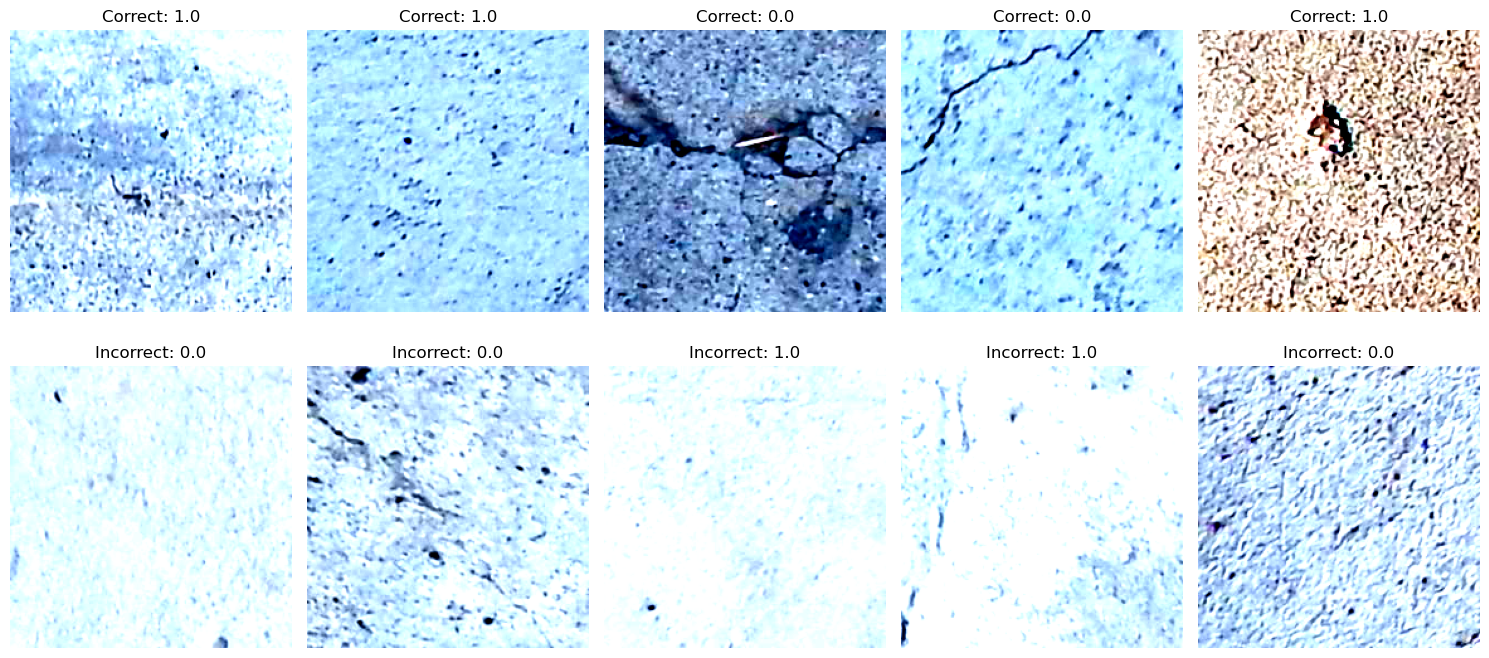

<Figure size 640x480 with 0 Axes>

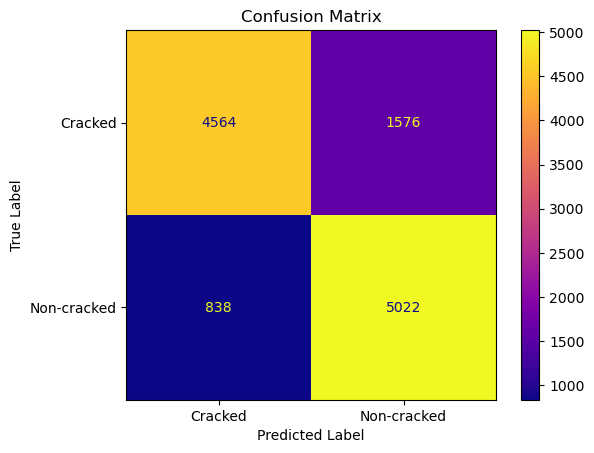

In [9]:
# Display predictions
print(sampled_data.classes)
# Plot correct and incorrect predictions in the same subplot
plt.figure(figsize=(15, 15))
for i, (image, label) in enumerate(correct_predictions):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    plt.title(f"Correct: {label.item()}")
    plt.axis('off')

for i, (image, label) in enumerate(incorrect_predictions):
    plt.subplot(2, 5, i+6)
    plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    plt.title(f"Incorrect: {label.item()}")
    plt.axis('off')
plt.tight_layout()    


plt.show()

# Confusion matrix
CM = confusion_matrix(CM_gt_label, CM_pred_label)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=sampled_data.classes)
disp.plot(cmap='plasma')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()